# Where does science stand on the closed universe conundrum?

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# show result from all calculations of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys, platform, os
from importlib import reload
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy as sp
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM

In [2]:
# CAMB from pip install
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))


Using CAMB 1.0.7 installed at /opt/conda/envs/cosmos3/lib/python3.7/site-packages/camb


In [3]:
# Have you installed arviz?
# This is just for some easy of visualizations. Not strictly needed.
try:
    import arviz as az
except ImportError:
    import sys
    !{sys.executable} -m pip install arviz
    import arviz as az

In [4]:
try:
    import getdist
    ver = getdist.__version__
    if int(ver[0:1]) >= 1:
        pass
    else:
        !{sys.executable} -m pip install --upgrade getdist
        reload(getdist)
except ImportError:
    import sys 
    !{sys.executable} -m pip install --upgrade getdist
    import getdist

In [5]:
import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op

In [31]:
from getdist import plots, MCSamples

## Isotropic Universe(FRLW)

$$ \left( \frac{H}{H_0} \right) = \Omega_{r,0} a^{-4} + \Omega_{m,0} a^{-3} + \Omega_{k,0} a^{-2} + \Omega_{\Lambda,0}, \;\;\;\;\;\;\;\;\; a = \frac{1}{1+z}  $$
$a$ is the scale-factor of the universe, normalized such that $a = 1$ today.

$z$ is the redshift. 

$H = \frac{\dot a}{a}$ is the Hubble parameter.

$\Omega_i = \frac{8\pi G\rho_i}{3 H^2}$ is the density parameter for the i-th component of the universe.

### Cosmological Distances

$$d_L = \frac{d_M}{1+z}$$
$$d_M = \left\{ 
\begin{array} 
\frac{d_H}{\sqrt{\Omega_{k,0}}} \sinh \frac{d_C \sqrt{\Omega_{k,0}}}{d_H}  \\
 d_c   \\
\frac{d_H}{\sqrt{\Omega_{k,0}}} \sin \frac{d_C \sqrt{\Omega_{k,0}}}{d_H}  
\end{array}
\right.$$
$$d_C = d_H\int_0^z \frac{\mathrm{dz}}{\sqrt{\Omega_{r,0}a^{-4} + \Omega_{m,0}a^{-3} + + \Omega_{k,0}a^{-2}+ \Omega_{\Lambda,0}}}$$
$$d_H = \frac{c}{H_0} $$
Which are the **Luminosity**, **Transverse Comoving**, **Comoving** and **Hubble Distances** respectively.

In [6]:
# Generate Cosmologies
K = [0.0,0.9,-0.5]
cambPar = camb.CAMBparams()
rCosm = [ camb.get_background(
                cambPar.set_cosmology(
                    H0=67.66, ombh2=0.02234, omch2=0.11907, omk=kk))
         for kk in K]
H_0 = [rCosm[ii].h_of_z(0) for ii in np.arange(len(rCosm))]
z = np.linspace(0,100,1000)
Dist = [[H_0[ii]*rCosm[ii].angular_diameter_distance(z),
                    H_0[ii]*rCosm[ii].luminosity_distance(z),
                    H_0[ii]*rCosm[ii].comoving_radial_distance(z)]
                   for ii in np.arange(len(rCosm))]


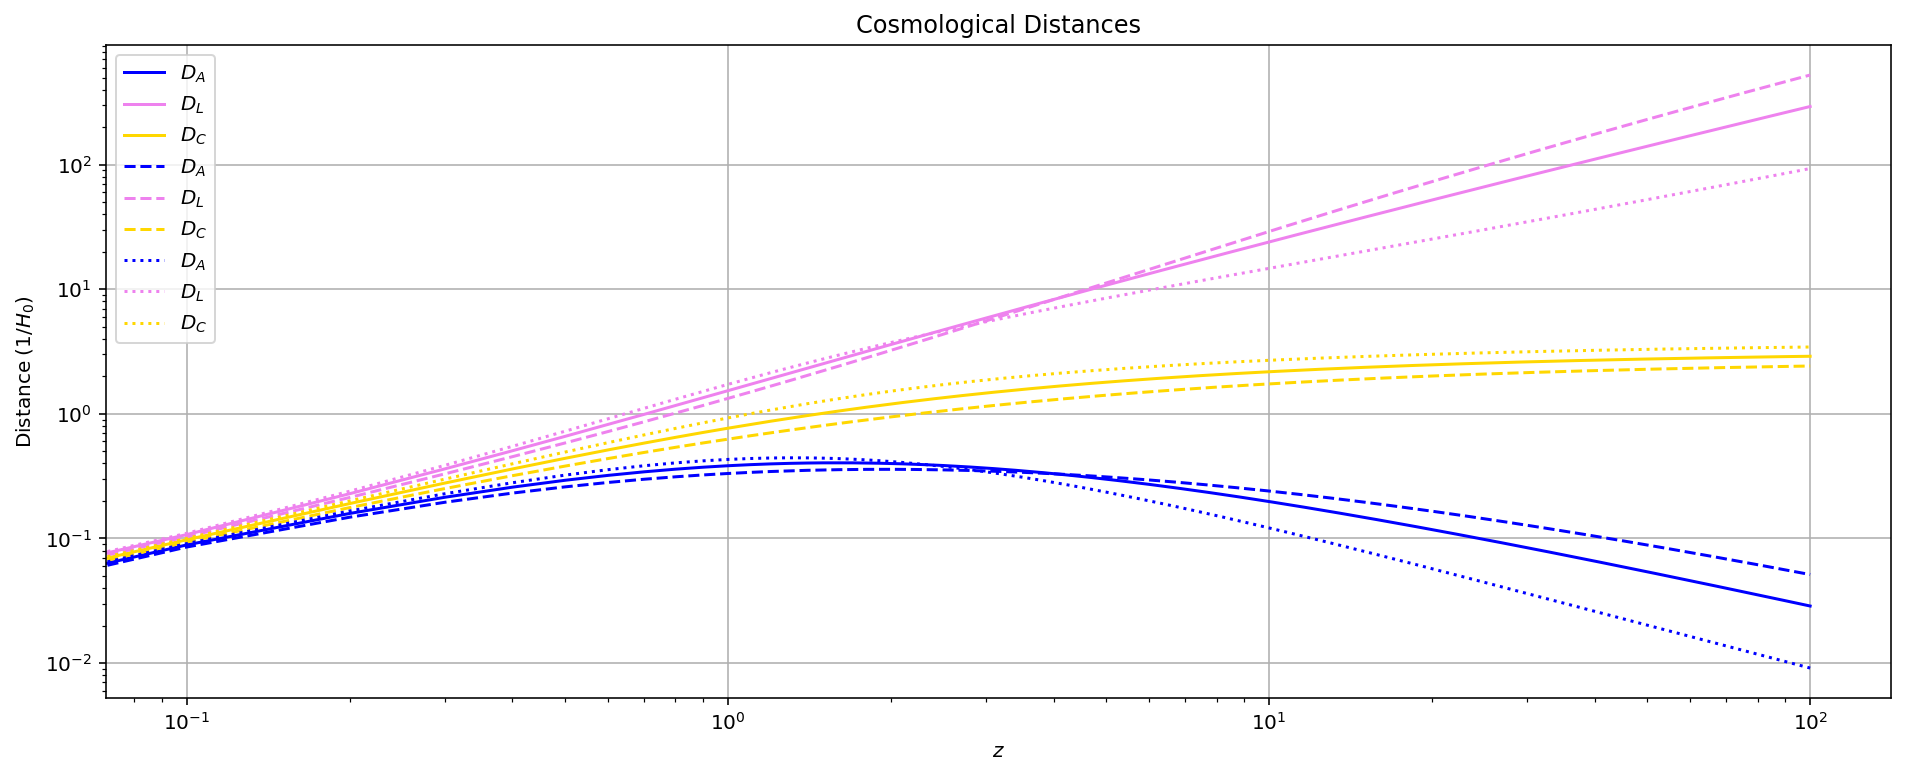

In [7]:
# Different Distances & Different Geometries
styles = ["solid", "dashed", "dotted"]
fig, ax = plt.subplots(figsize = (16,6))
for ii in np.arange(len(rCosm)):
    ax.plot(z, Dist[ii][0], color = "blue", label = r'$D_A$', linestyle = styles[ii] )
    ax.plot(z, Dist[ii][1], color = "violet", label = r'$D_L$', linestyle = styles[ii] )
    ax.plot(z, Dist[ii][2], color = "gold", label = r'$D_C$', linestyle = styles[ii] )
    ax.set_title("Cosmological Distances")
    ax.set_xlabel("$z$")
    ax.set_ylabel("$\mathrm{Distance}\; (1/H_0)$")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
plt.grid()
plt.show();

### Fates of Universes

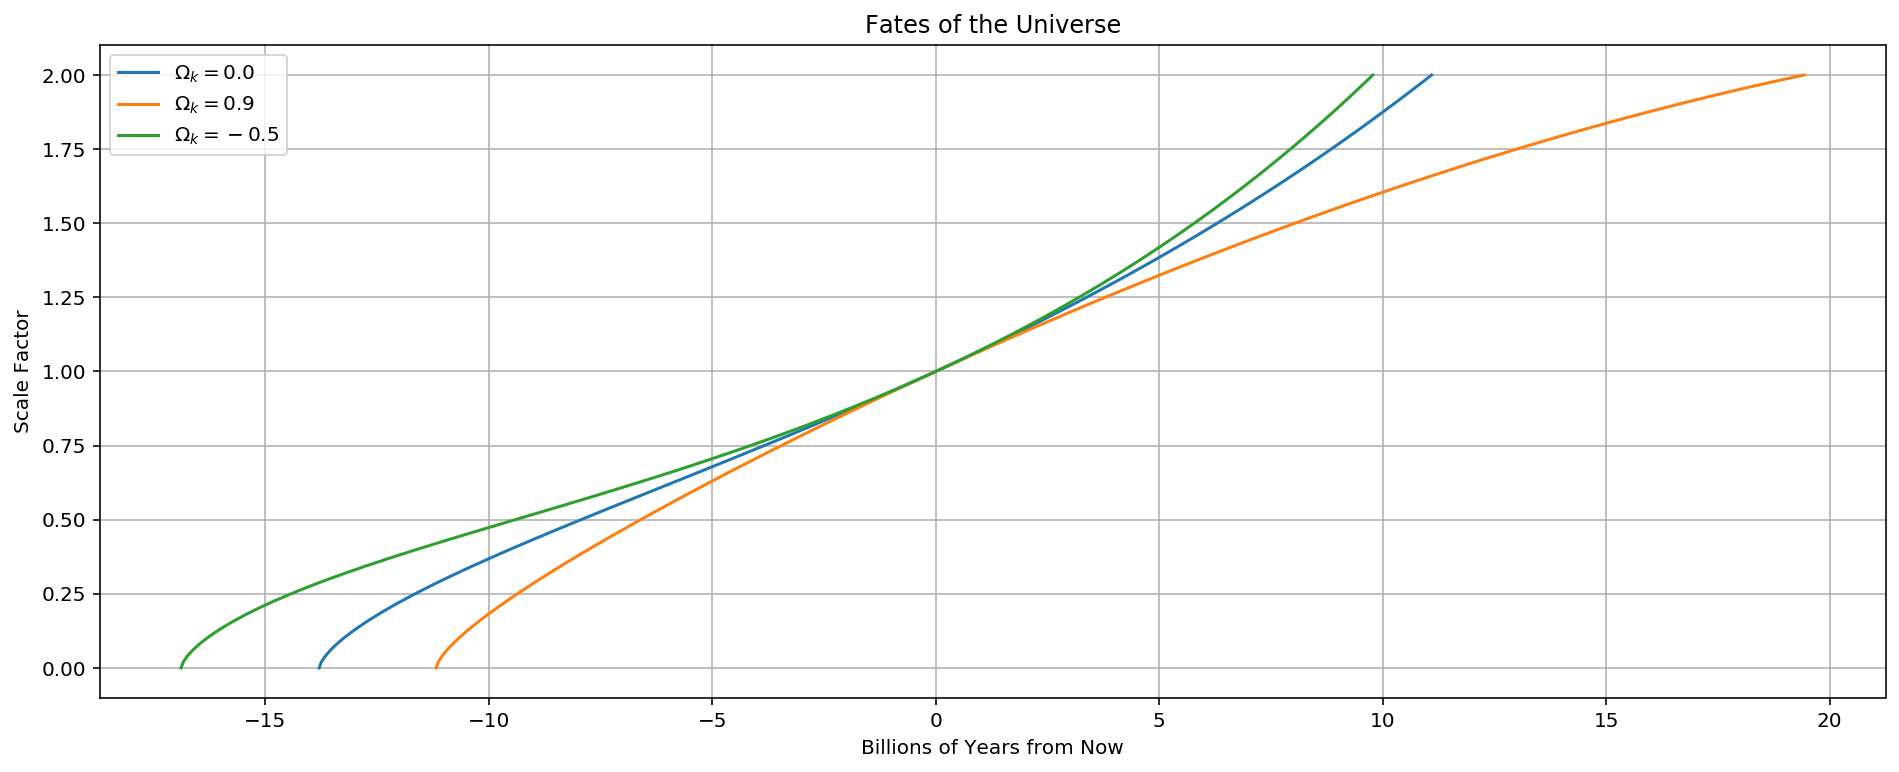

In [8]:
a = np.linspace(0,2,100)
age = [rCosm[ii].physical_time_a1_a2(0,1) for ii in np.arange(len(rCosm))]
tt = [ np.array(
                [rCosm[ii].physical_time_a1_a2(0,ai)
                 for ai in a]) - age[ii] 
      for ii in np.arange(len(K))]

fig = plt.subplots(figsize = (16,6))
for ii in [0,1,2]:
    plt.plot(tt[ii],a, label=r'$\Omega_k={}$'.format(K[ii]))
    plt.xlabel("Billions of Years from Now")
    plt.ylabel("Scale Factor")
    plt.title("Fates of the Universe")
    plt.legend()
plt.grid()
plt.show();

## Supernovas

We are going to use the UNION 2.1 dataset (http://supernova.lbl.gov/Union/) and some of he discussion will follow https://arxiv.org/abs/1401.4064 (Betole et Al). First we will discuss thing in a simpler context.

In [9]:
#Point syspath to find out lessons module
import os
import sys
sys.path.append('/home/cosmos/code/cosmos/lessons/')
from supernova import Supernova

We already constructed several functions wrapped in a class to discuss Supernova Data from a standard frequantist point of view.. We may plot distance modules $\mu(z)$, we may write the luminosity distance from it and write the propagation error for this.

We already considered fitting this model for a linear model (standard Hubble Law), a quadratic model (including the decelleration parameter) and we also fit the data using the full FRW model (without curvature).

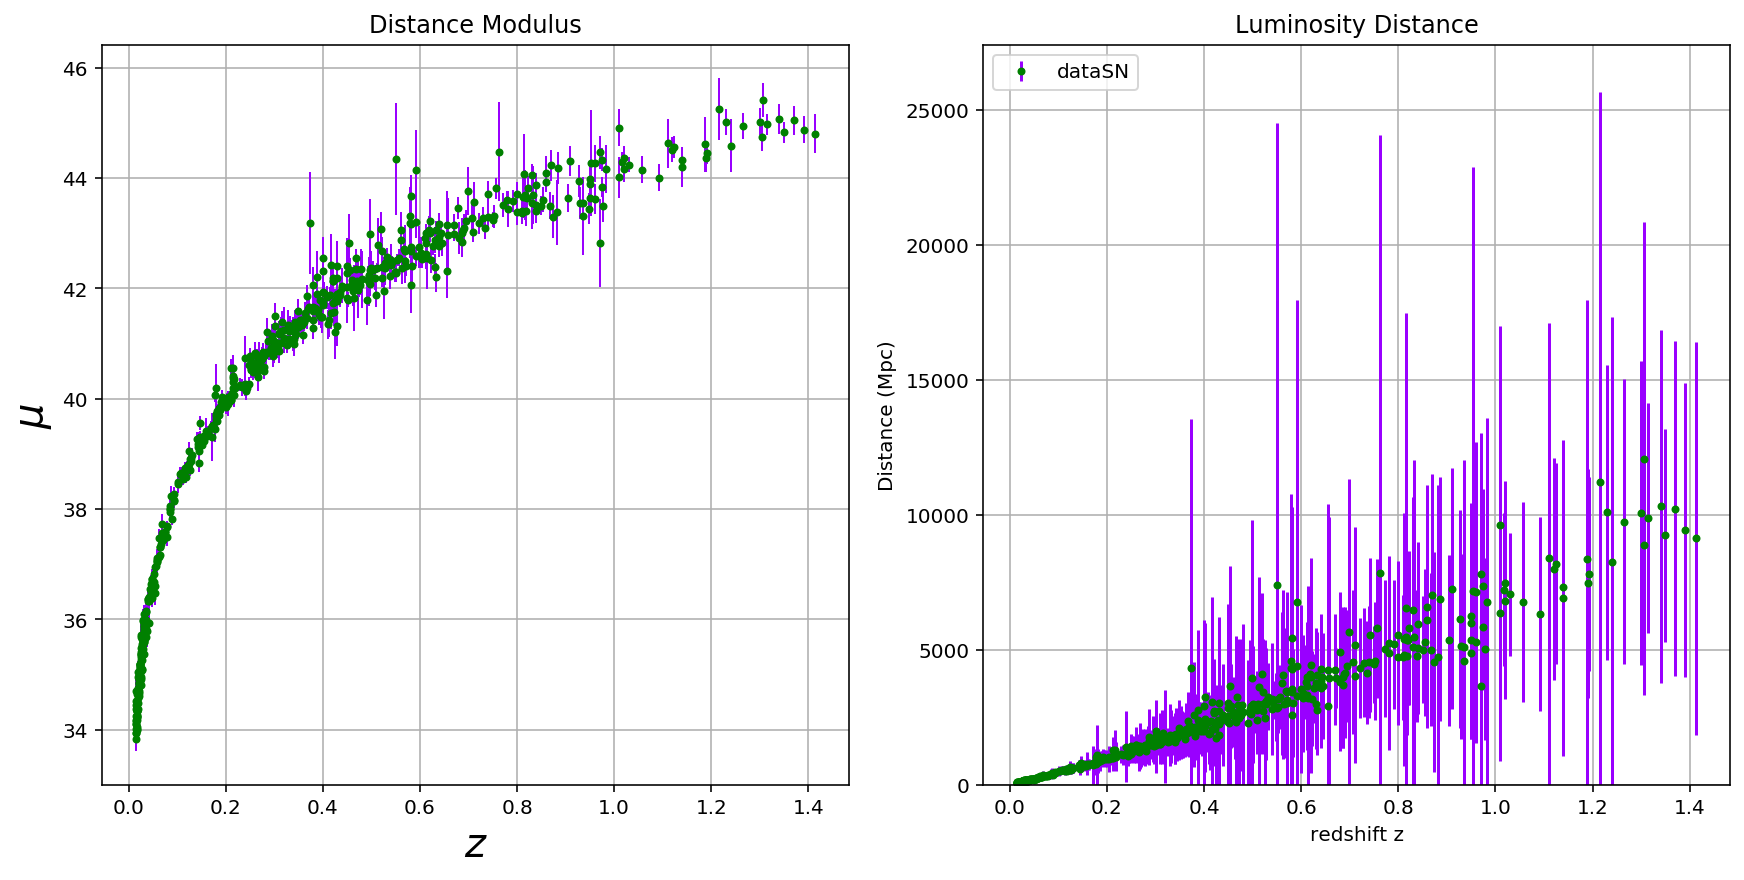

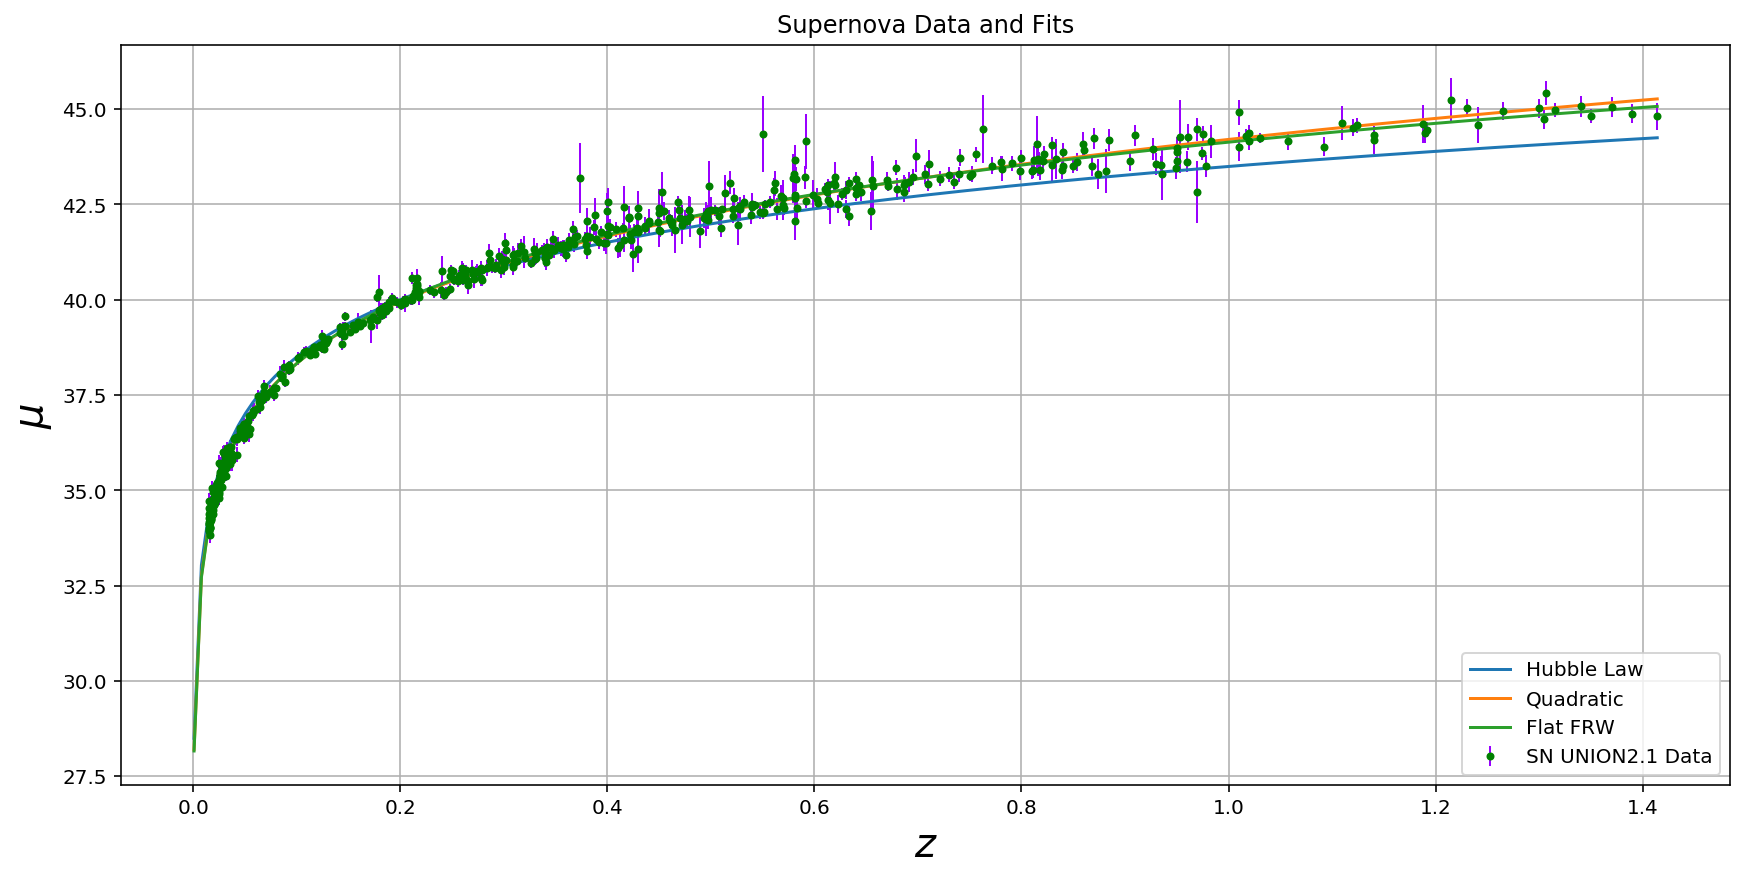

In [10]:
# Instantiate the Supernova class to fetch the data
SN = Supernova()
SN.plotDataToZ()
SN.plotFitZ();

In [11]:
print("flatFRW Model Parameters= ", 
      SN.fitDataMu(FIT = "FRW")[0].tolist())

flatFRW Model Parameters=  [70.00241539765383, 0.2776122297701926]


We will consider all this questions again, but in a bayesian setting, we will discuss how to define a likelyhood function, confidence intervals and we are considering different models. Their difference is in the number of parameters to be considered (with or without curvature and with or without nuisance parameters).

The approach for this first part will be pythoc and we will use the module PYMC3 as the sampler. Care must be taken in order to use its full power (Hamiltonian Monte Carlo) but the first Metropolic-Hasting approach will be almost straighforward.

In [12]:
def cosmoBackground(H0 = 70, O_m = 0.3, O_L = 0.7, O_k = 0):
    params = {"H0":70, "O_m":0.3,"O_L":0.7,"O_k":0}
    params["ombh2"] = 0.022
    params["omch2"] = O_m*(H0/100)**2
    params["omk"] = O_k 
    params["O_k"]=1-O_L - O_m
    
    return params

In [15]:
# CAMB luminosity function
def Luminosity_Distance(z, H0, O_m, O_L, O_k):
    H0, ombh2, omch2, omk = (
                                cosmoBackground(H0, O_m, O_L,O_k)[key] 
                                                                for key in ["H0", "ombh2", "omch2", "omk"]
    )
    cambPar = camb.CAMBparams()
    rCosm = camb.get_background(
        cambPar.set_cosmology(
            H0=H0, ombh2=ombh2, omch2=omch2, omk=omk)
    )
    Dist = rCosm.luminosity_distance(z)    
    return Dist

In [16]:
H0=67.66; O_m = 0.3104; O_L = 0.6896 

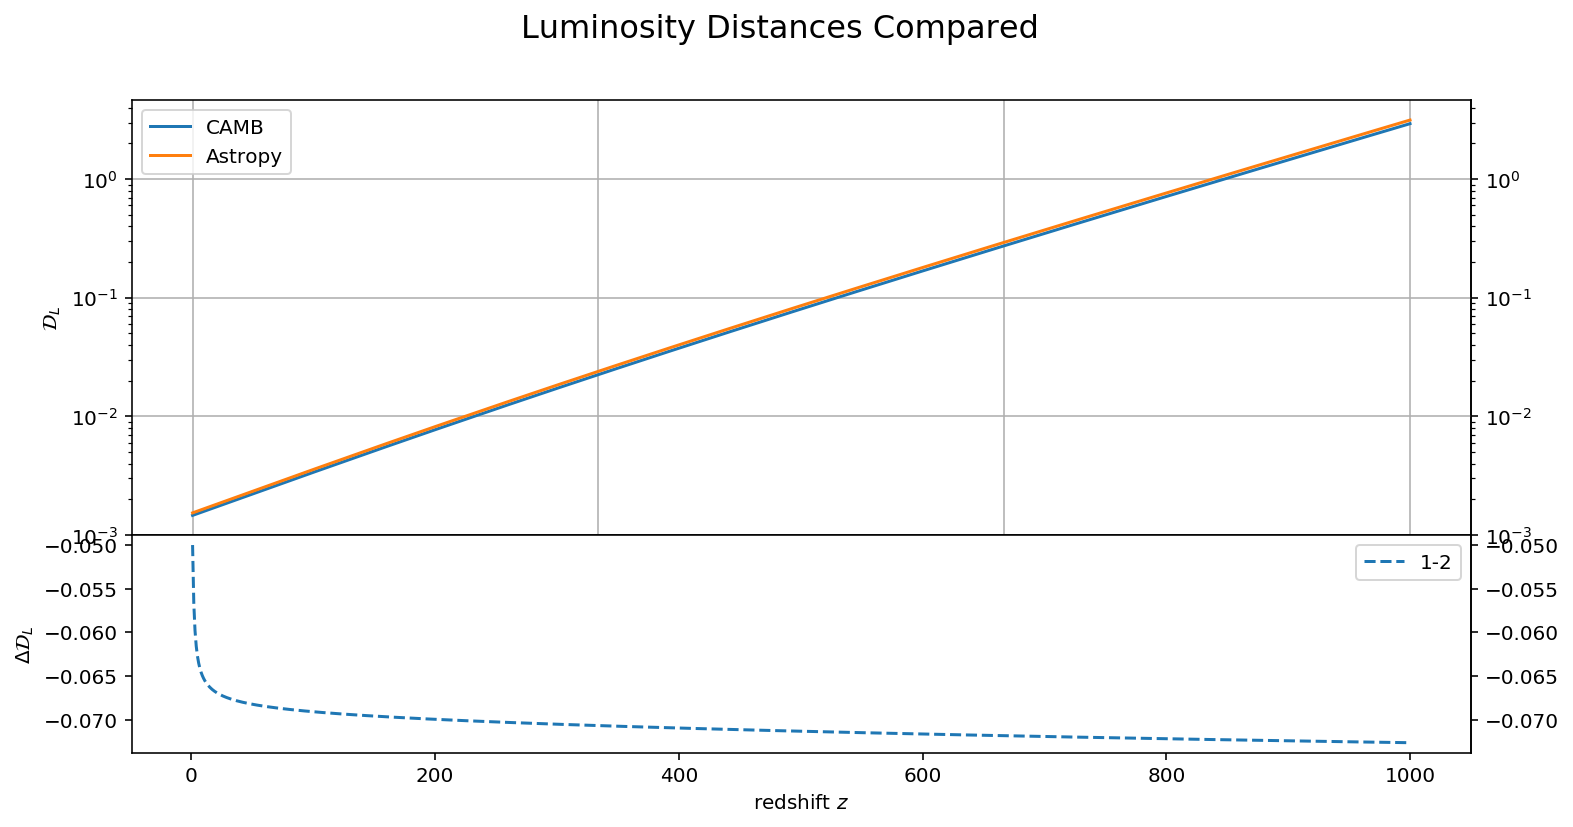

In [17]:
from scipy.constants import c 

z = np.linspace(1,1000,1000)

cosmoF = FlatLambdaCDM(H0=H0, Om0=O_m)


DL1 = H0/c*Luminosity_Distance(z,H0 = H0, O_m = O_m, O_L = O_L, O_k = 0)
DL2 = H0/c*cosmoF.luminosity_distance(z).value
Delta_DL12 = (DL1-DL2)/DL1
fig = plt.figure()
gs = gridspec.GridSpec(3, 1, hspace = 0)
ax1 = fig.add_subplot(gs[:2, 0])
ax1.plot(z,DL1, label = "CAMB")
ax1.plot(z,DL2, label = "Astropy")
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.label_outer()
ax1.secondary_yaxis("right")
plt.grid()
plt.legend()
ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(z,Delta_DL12, 
         linestyle = "dashed", label = "1-2")
fig.suptitle('Luminosity Distances Compared', fontsize=16)
ax1.set_ylabel(r"$\mathcal{D}_L$")
ax2.set_ylabel(r"$\Delta\mathcal{D}_L$")
ax2.set_xlabel(r"redshift $z$")
ax2.secondary_yaxis("right")
plt.legend()
plt.show();

In [18]:
z = np.linspace(0,10,100)
%timeit D_LsCAMB = [Luminosity_Distance(zz,H0 = H0, O_m = O_m, O_L = O_L, O_k = 0) for zz in z]
# The best options we have to calculate the distances
%timeit cosmoF.luminosity_distance(z).value


6.06 s ± 66.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
240 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Flat Universe

We will choose the parameters $H_0$ and $\Omega_{m,0}$ to describe our model. The Dark Energy is simply given by $\Omega_{\Lambda,0}$.

The observable $\mu(z;\theta)$ is obtained from the luminosity distance, which in turn depends on our parameters. We car write our likelyhood as:

$$\mathcal{L} = P(\mu,z|H_0,\Omega_m) = \frac{1}{\sqrt{\mathrm{det}\;2\pi\Sigma}} \mathrm{exp} \left(-\frac{1}{2} \left[ \mu - \hat\mu(H_0,\Omega_m)\right]^T \Sigma^{-1} \left[ \mu - \hat\mu(H_0,\Omega_m)\right]  \right)$$

In [19]:
# Fetch Data
SN = np.genfromtxt("../DATA/SCPUnion2.1_mu_vs_z.txt")

order = SN[:, 1].argsort()
zs = SN[:, 1][order]
mods = SN[:, 2][order]


In [20]:
# Fetch the covariance matrix
Sigma = np.genfromtxt("../DATA/SCPUnion2.1_covmat_sys.txt")[order, :][:, order]
Sigma_no = np.genfromtxt("../DATA/SCPUnion2.1_covmat_nosys.txt")[order, :][:, order]

mod_errs = [np.sqrt(Sigma[i, i]) for i, _ in enumerate(Sigma)]
mu = mods

mod_errs_no = [np.sqrt(Sigma_no[i, i]) for i, _ in enumerate(Sigma_no)]


# Invert the covariance Matrix
invSigma = np.linalg.inv(Sigma)
invSigma_no = np.linalg.inv(Sigma_no)
# calculate the prefactor of the likelyhood Det(2 pi Sigma)
# The function return a signal and the log(det(a))
# underscores ignores the first element of the returning tuple
_, LogDetSigma = np.linalg.slogdet(2*np.pi*Sigma)
_, LogDetSigma_no = np.linalg.slogdet(2*np.pi*Sigma_no)

In [21]:
# These functios already incorporate the DATA
# They are function only of the parameters H0 and OmM
# We are using the distmod function from astropy
# no suffx indate covariance with no systematics considered.

def log_likelihood(H0 = 60, OmM = 0.3):
    cosmoF = FlatLambdaCDM(H0=H0, Om0=OmM)
    mods = cosmoF.distmod(zs).value
    Delta = mu - mods
    return -LogDetSigma/2. - Delta.dot(invSigma.dot(Delta))/2.

def log_likelihood_no(H0 = 60, OmM = 0.3):
    cosmoF = FlatLambdaCDM(H0=H0, Om0=OmM)
    mods = cosmoF.distmod(zs).value
    Delta = mu - mods
    return -LogDetSigma_no/2. - Delta.dot(invSigma_no.dot(Delta))/2.


In [22]:

# Prepare the LokLikelyHood to be a Theano Tensor of Random Variables
# It MUST return a NUMPY object
# The inputs will be Random Variables
@as_op(itypes=[T.dscalar, T.dscalar], otypes=[T.dscalar])
def logp(a,b):
    return np.array(log_likelihood(H0 = a, OmM = b))

@as_op(itypes=[T.dscalar, T.dscalar], otypes=[T.dscalar])
def logp_no(a,b):
    return np.array(log_likelihood_no(H0 = a, OmM = b))

# Our Model has Uniform Priors and a Potential only, since all the observed data
# is already contained in the functions.
# Inside the model we need to create a determinist random variable (energy) to use
# inside the potential
with pm.Model() as model:
    H0 = pm.Uniform('H0', 60, 80)
    OmM = pm.Uniform("OmM", 0, 1)
    
    energy = logp(H0, OmM)
    like = pm.Potential('energy', energy)

with pm.Model() as model_no:
    H0 = pm.Uniform('H0', 60, 80)
    OmM = pm.Uniform("OmM", 0, 1)
    
    energy = logp_no(H0, OmM)
    like = pm.Potential('energy', energy)  

In [23]:
# Our likelyhood is not a native Theano object, there is no known Gradient 
# So only MonteCarlo-Hastings and Slice will work as sampling methods.
# NOTE: We can implement a gradient method later
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, cores = 7)

#with model_no:
#    step = pm.Metropolis()
#    trace_no = pm.sample(5000, step=step, cores = 7)

Multiprocess sampling (7 chains in 7 jobs)
CompoundStep
>Metropolis: [OmM]
>Metropolis: [H0]
Sampling 7 chains: 100%|██████████| 10500/10500 [02:10<00:00, 80.38draws/s] 
The number of effective samples is smaller than 10% for some parameters.


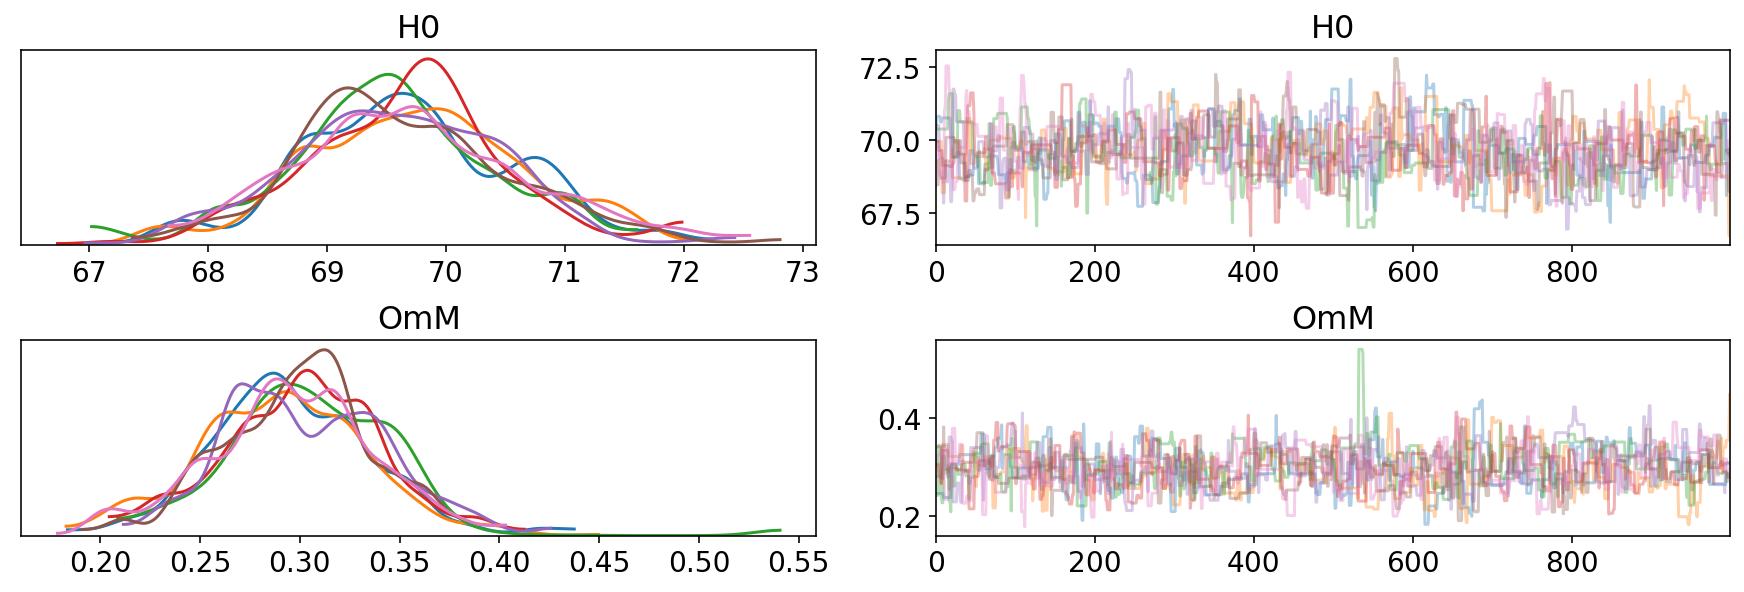

In [25]:
az.plot_trace(trace);
#az.plot_trace(trace_no);

In [26]:
az.summary(trace)
#az.summary(trace_no)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
H0,69.651,0.897,67.939,71.367,0.045,0.032,405.0,405.0,403.0,628.0,1.01
OmM,0.299,0.040,0.221,0.371,0.002,0.001,433.0,433.0,429.0,786.0,1.02


In [28]:
# O_L is not an independent parameter
O_L = 1 - trace["OmM"]
#O_L_no = 1 - trace_no["OmM"]

Removed 0.3 as burn in


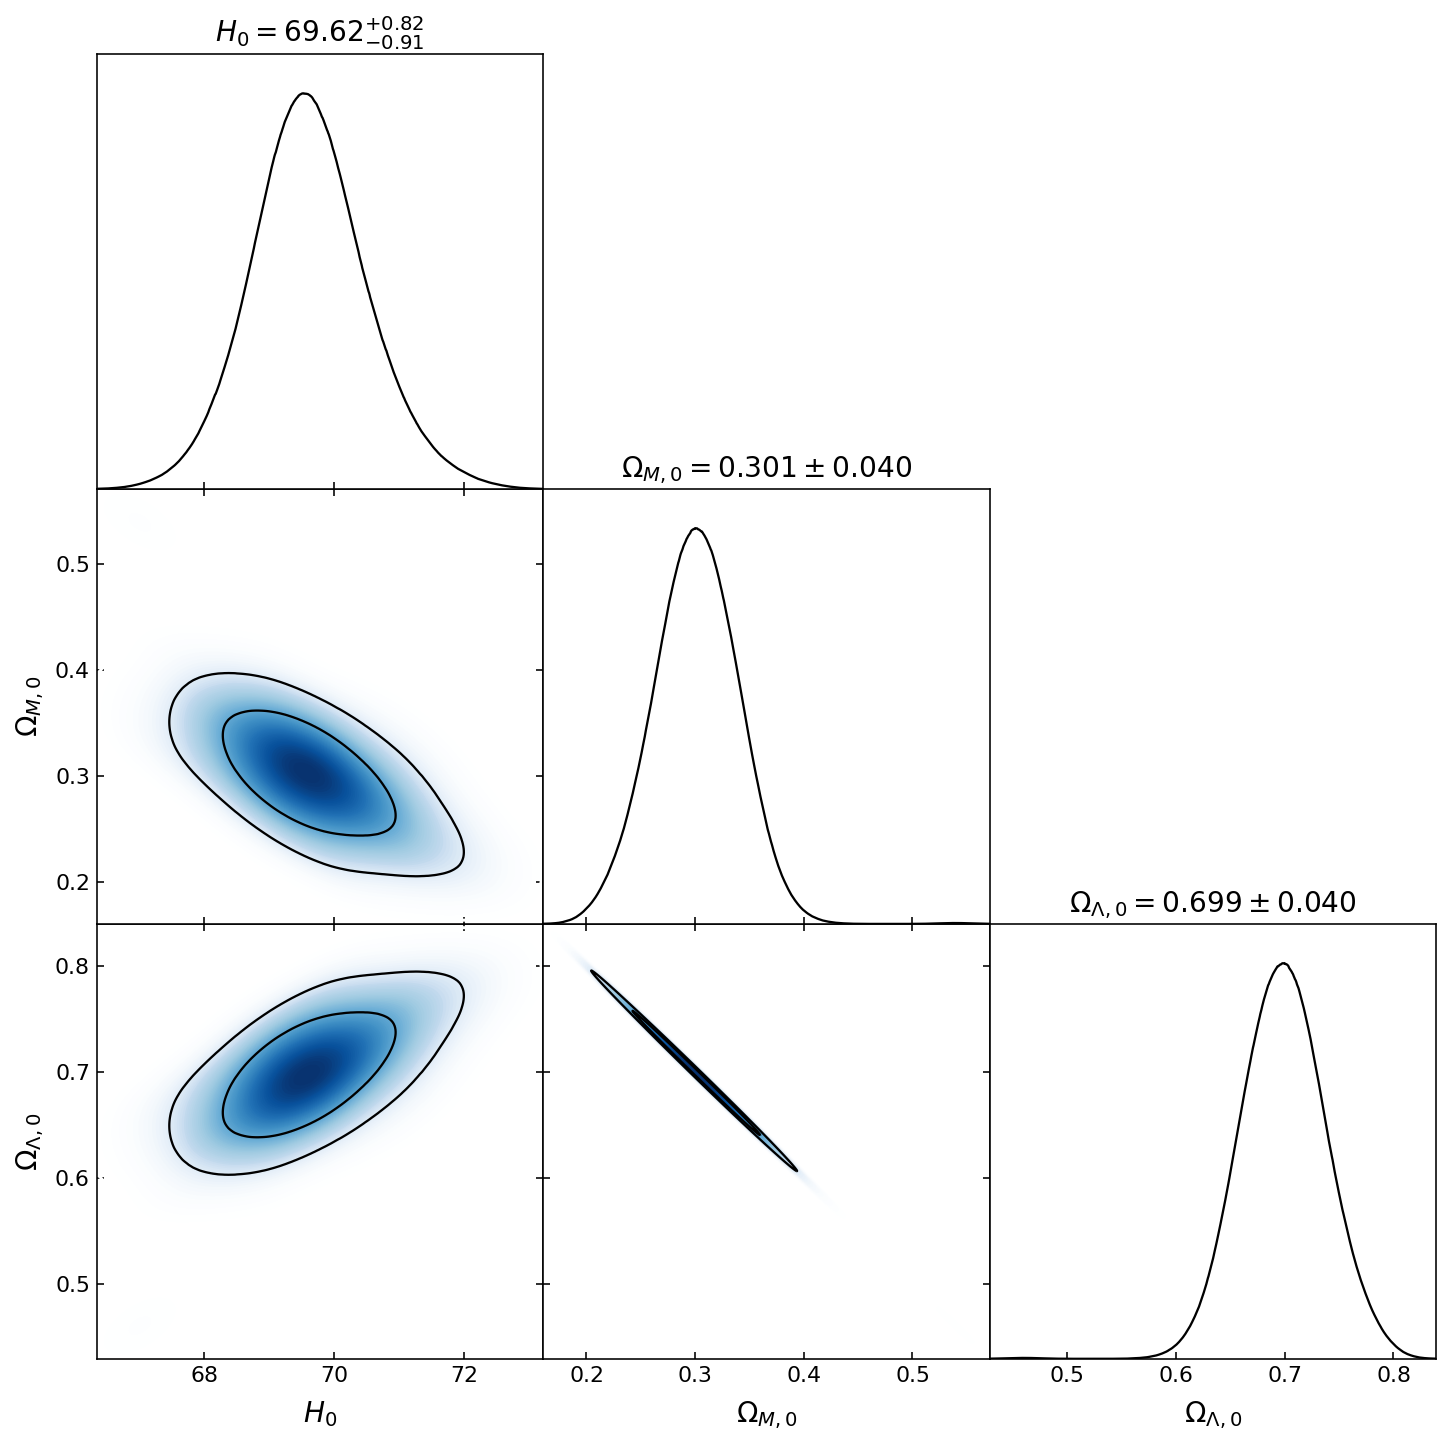

In [32]:
# extract the traces and plot the results
pymc_trace = np.asarray([trace['H0'][:], trace['OmM'][:],  O_L]).T
#pymc_trace_no = np.asarray([trace_no['H0'][:], trace_no['OmM'][:],  O_L_no]).T
names = ["H0", "OmM", "O_L"]
labels =  [r'H_0', r'\Omega_{M,0}', r'\Omega_{\Lambda,0}']
samples = MCSamples(samples=pymc_trace, 
                    names = names, 
                    labels = labels, 
                    label = "Systematics Corrected", 
                    settings={'ignore_rows':0.3})
#samples_no = MCSamples(samples=pymc_trace_no,
#                       names = names,
#                       labels = labels,
#                       label = "No Correction",
#                       settings={'ignore_rows':0.3})
# Triangle plot
g = plots.get_subplot_plotter(width_inch=12)
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples],
                shaded=True,
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'alpha':27})
# g.export("bayes.png") #Save?

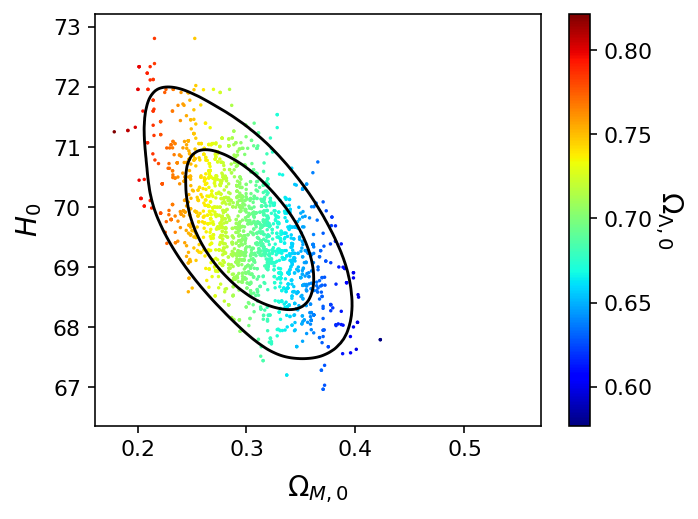

In [33]:
# 2D scatter (3D) plot
g = plots.get_single_plotter(width_inch=5)
g.plot_3d([samples,samples], ["OmM", "H0","O_L"])

In [34]:
# Credible Interval
z_range = np.linspace(0.01 ,1.5*max(zs),50)
traceH =trace["H0"]
traceO =trace["OmM"]
# Sample de posterior with chains and calculate statistisc for percentiles
mu_hat = np.asarray([ FlatLambdaCDM(H0=x[0], Om0=x[1]).distmod(z_range).value for x in zip(traceH, traceO)])
bounds = np.percentile(mu_hat, 100 * sp.stats.norm.cdf([-1.65, 1.65]), axis = 0)

## Best Fit 
H0fit = trace["H0"].mean()
OmMfit = trace["OmM"].mean()
mu_hat_best = FlatLambdaCDM(H0=H0fit, Om0=OmMfit).distmod(z_range).value

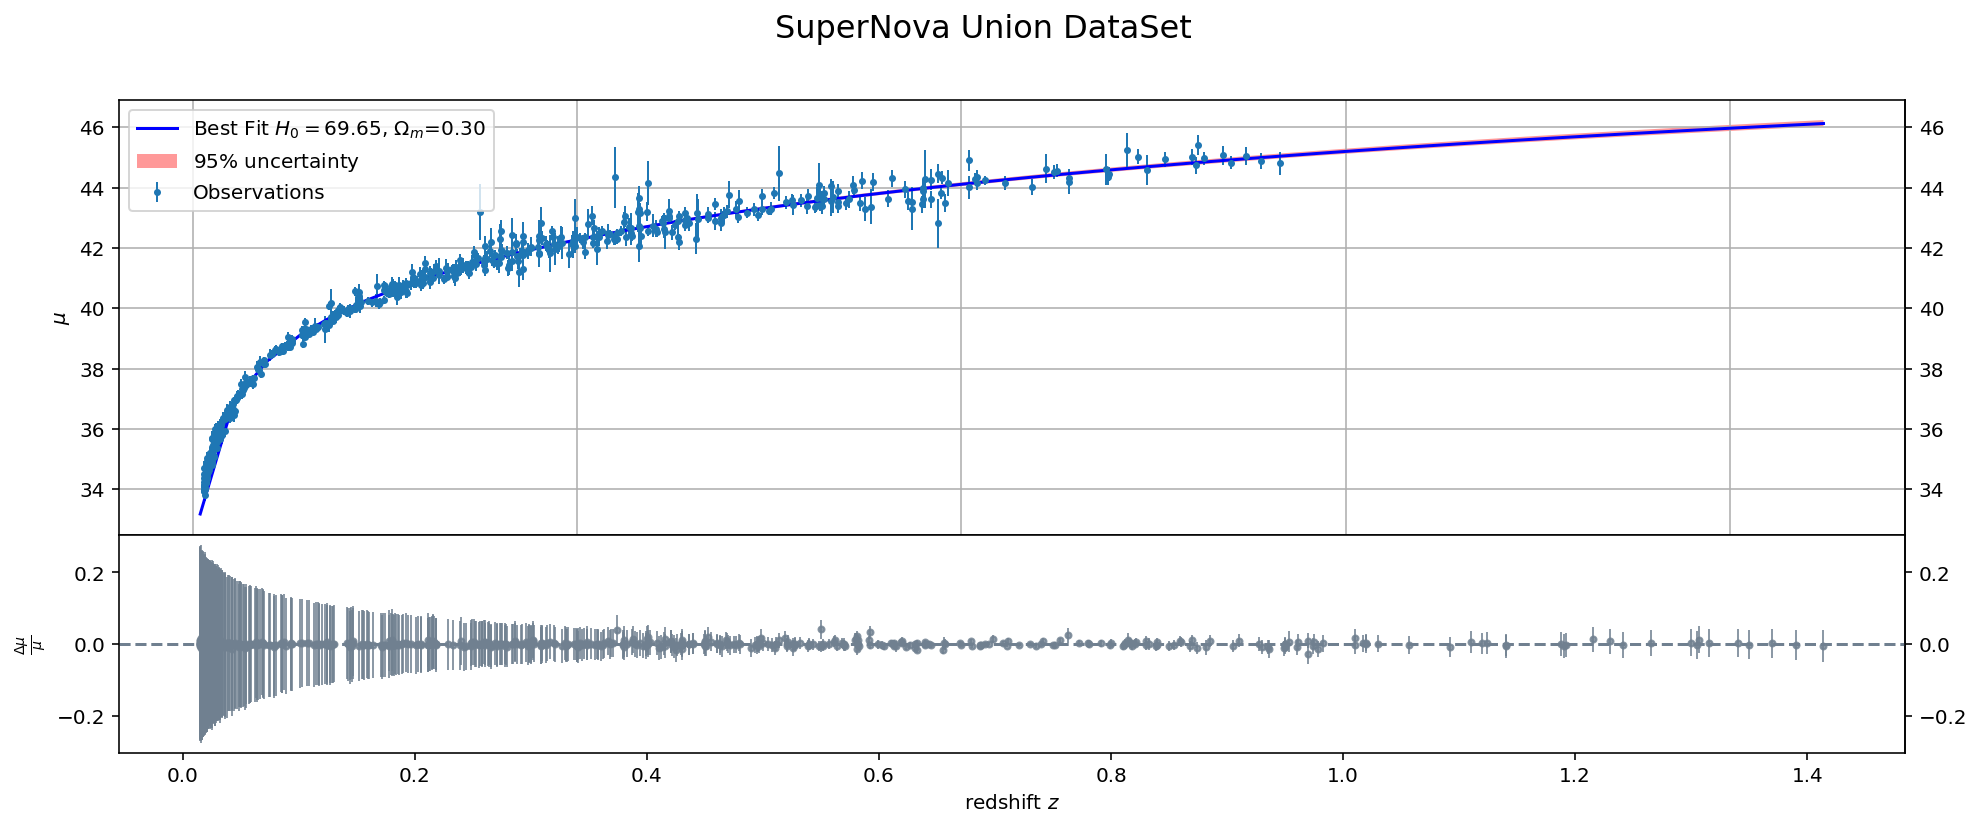

In [35]:
# This is for the error Bars: Bounds calculated in the same range of data
# predictions for the same z as the data
# Error bars from standard propagation
mu_hat_loc = FlatLambdaCDM(H0=H0fit, Om0=OmMfit).distmod(zs).value
boundsPanel = np.percentile(mu_hat_loc, 100 * sp.stats.norm.cdf(1), axis = 0)
delta = np.asarray((mu - mu_hat_loc)/mu)
error_Panel = delta * np.sqrt(
    (mod_errs/mu)**2 +
    ((np.sqrt(np.asarray(mod_errs)**2 +(mu_hat_loc-boundsPanel)**2))/(mu-mu_hat_loc))**2)

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(3, 1, hspace = 0)
ax1 = fig.add_subplot(gs[:2, 0])
ax1.errorbar(zs, mu, yerr = mod_errs, fmt = ".", label = "Observations", ms = 5, lw = 1)
ax1.plot(z_range, mu_hat_best, 
         label = r"Best Fit $H_0=${h0:.2f}, $\Omega_m$={om:.2f}".format(h0 = trace["H0"].mean(), 
                                                                        om = trace["OmM"].mean()), 
         c = "blue")
ax1.fill_between(z_range, bounds[0, :], bounds[-1, :], 
                 label=r"$95\%$ uncertainty", fc="red", alpha=0.4)
ax1.set_ylabel(r"$\mu$")
ax1.label_outer()
ax1.secondary_yaxis("right")
plt.grid()
plt.legend()
ax2 = fig.add_subplot(gs[2, 0])
fig.suptitle('SuperNova Union DataSet', fontsize=16)
ax2.errorbar(zs, delta, yerr = error_Panel, 
             label = "Deviation", 
             c = "slategray", 
             fmt=".", 
             lw = 1, 
             alpha = 0.8)
ax2.axhline(0, linestyle = "dashed", c = "slategray")
ax2.set_ylabel(r"$\frac{\Delta\mu}{\mu}$")
ax2.set_xlabel(r"redshift $z$")
ax2.secondary_yaxis("right")
#plt.legend()
#plt.savefig('NiceSupernova.png')
plt.show();

## Curved Universe

We are going to consider the possibility of $\Omega_k \neq 0$. We will have one more parameter in our model:$H_0$, $\Omega_{m,0}$ and $\Omega_\Lambda$. We will consider the curvature as a derived parameter:

$$\Omega_{k,0} = 1 - \Omega_{\Lambda,0} - \Omega_{m,0}$$.

The observable $\mu(z;\theta)$ is obtained from the luminosity distance, which in turn depends on our parameters. We can write our likelyhood as:

$$\mathcal{L} = P(\mu,z|H_0,\Omega_m, \Omega_\Lambda) = \frac{1}{\sqrt{\mathrm{det}\;2\pi\Sigma}} \mathrm{exp} \left(-\frac{1}{2} \left[ \mu - \hat\mu(H_0,\Omega_m, \Omega_\Lambda)\right]^T \Sigma^{-1} \left[ \mu - \hat\mu(H_0,\Omega_m, \Omega_k)\right]  \right)$$

In [36]:
# The change in likelyhoods is very trivial, since astropy already incorporate the change we need.

# These functions already incorporate the DATA
# They are function only of the parameters H0 and OmM
# We are using the distmod function from astropy
# no suffix indicate covariance with no systematics considered.

def log_likelihood(H0 = 60, OmM = 0.3, O_L=0.7):
    cosmoF = LambdaCDM(H0=H0, Om0=OmM, Ode0=O_L)
    mods = cosmoF.distmod(zs).value
    Delta = mu - mods
    return -LogDetSigma/2. - Delta.dot(invSigma.dot(Delta))/2.

def log_likelihood_no(H0 = 60, OmM = 0.3, O_L = 0.7):
    cosmoF = LambdaCDM(H0=H0, Om0=OmM, Ode0=O_L)
    mods = cosmoF.distmod(zs).value
    Delta = mu - mods
    return -LogDetSigma_no/2. - Delta.dot(invSigma_no.dot(Delta))/2.


In [37]:
# We should incorporate the new parameter in the likelyhood

# Prepare the LokLikelyHood to be a Theano Tensor of Random Variables
# It MUST return a NUMPY object
# The inputs will be Random Variables
@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar], otypes=[T.dscalar])
def logp(a,b,c):
    return np.array(log_likelihood(H0 = a, OmM = b, O_L=c))

@as_op(itypes=[T.dscalar, T.dscalar, T.dscalar], otypes=[T.dscalar])
def logp_no(a,b,c):
    return np.array(log_likelihood_no(H0 = a, OmM = b, O_L = c))

# Our model has a prior for Dark Energy Density
# Our Model has Uniform Priors and a Potential only, since all the observed data
# is already contained in the functions.
# Inside the model we need to create a determinist random variable (energy) to use
# inside the potential
with pm.Model() as modelL:
    H0 = pm.Uniform('H0', 60, 80)
    OmM = pm.Uniform("OmM", 0, 1)
    O_L = pm.Uniform("O_L",0,1)
    
    energy = logp(H0, OmM, O_L)
    like = pm.Potential('energy', energy)

with pm.Model() as modelL_no:
    H0 = pm.Uniform('H0', 60, 80)
    OmM = pm.Uniform("OmM", 0, 1)
    O_L = pm.Uniform("O_L",0,1)
    
    energy = logp_no(H0, OmM, O_L)
    like = pm.Potential('energy', energy)  

In [38]:
# No need to change anything here but let's choose a different name
# We want to compare traces from different models.

# Our likelyhood is not a native Theano object, there is no known Gradient 
# So only MonteCarlo-Hastings and Slice will work as sampling methods.
# NOTE: We can implement a gradient method later
with modelL:
    step = pm.Metropolis()
    traceL = pm.sample(1000, step=step, cores = 7)

#with modelL_no:
#    step = pm.Metropolis()
#    traceL_no = pm.sample(5000, step=step, cores = 7)

Multiprocess sampling (7 chains in 7 jobs)
INFO:pymc3:Multiprocess sampling (7 chains in 7 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [O_L]
INFO:pymc3:>Metropolis: [O_L]
>Metropolis: [OmM]
INFO:pymc3:>Metropolis: [OmM]
>Metropolis: [H0]
INFO:pymc3:>Metropolis: [H0]
Sampling 7 chains: 100%|██████████| 10500/10500 [03:17<00:00, 53.14draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


Removed 0.3 as burn in


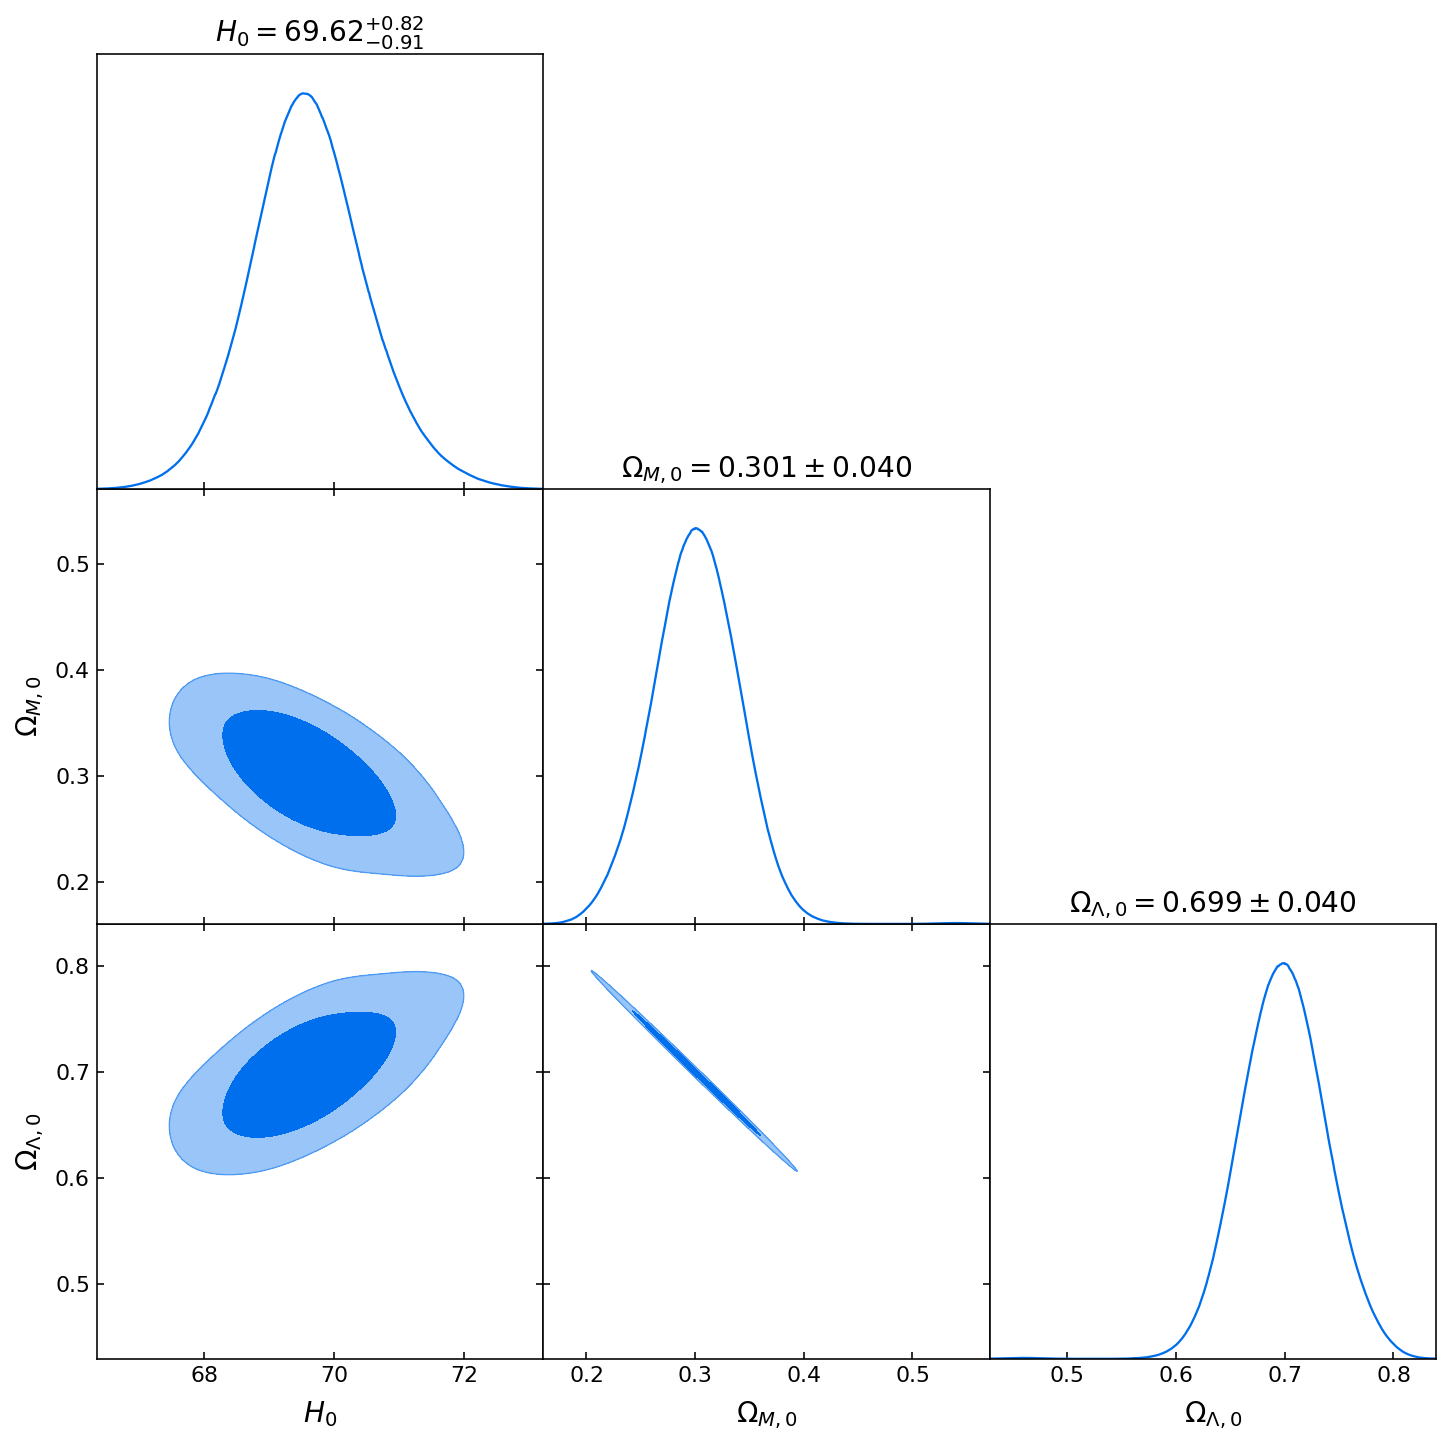

In [41]:
# extract the traces and plot the results
# O_L is not an independent parameter
pymc_trace = np.asarray([trace['H0'][:], trace['OmM'][:],  1 - trace["OmM"]]).T
#pymc_trace_no = np.asarray([trace_no['H0'][:], trace_no['OmM'][:],  1 - trace_no["OmM"]]).T
names = ["H0", "OmM", "O_L"]
labels =  [r'H_0', r'\Omega_{M,0}', r'\Omega_{\Lambda,0}']
samples = MCSamples(samples=pymc_trace, 
                    names = names, 
                    labels = labels, 
                    label = "Systematics Corrected", 
                    settings={'ignore_rows':0.3})
#samples_no = MCSamples(samples=pymc_trace_no,
#                       names = names,
#                       labels = labels,
#                       label = "No Correction",
#                       settings={'ignore_rows':0.3})
# Triangle plot
g = plots.get_subplot_plotter(width_inch=12)
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples],
                filled=True,
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'alpha':27})
# g.export("bayes.png") #Save?

Removed 0.3 as burn in


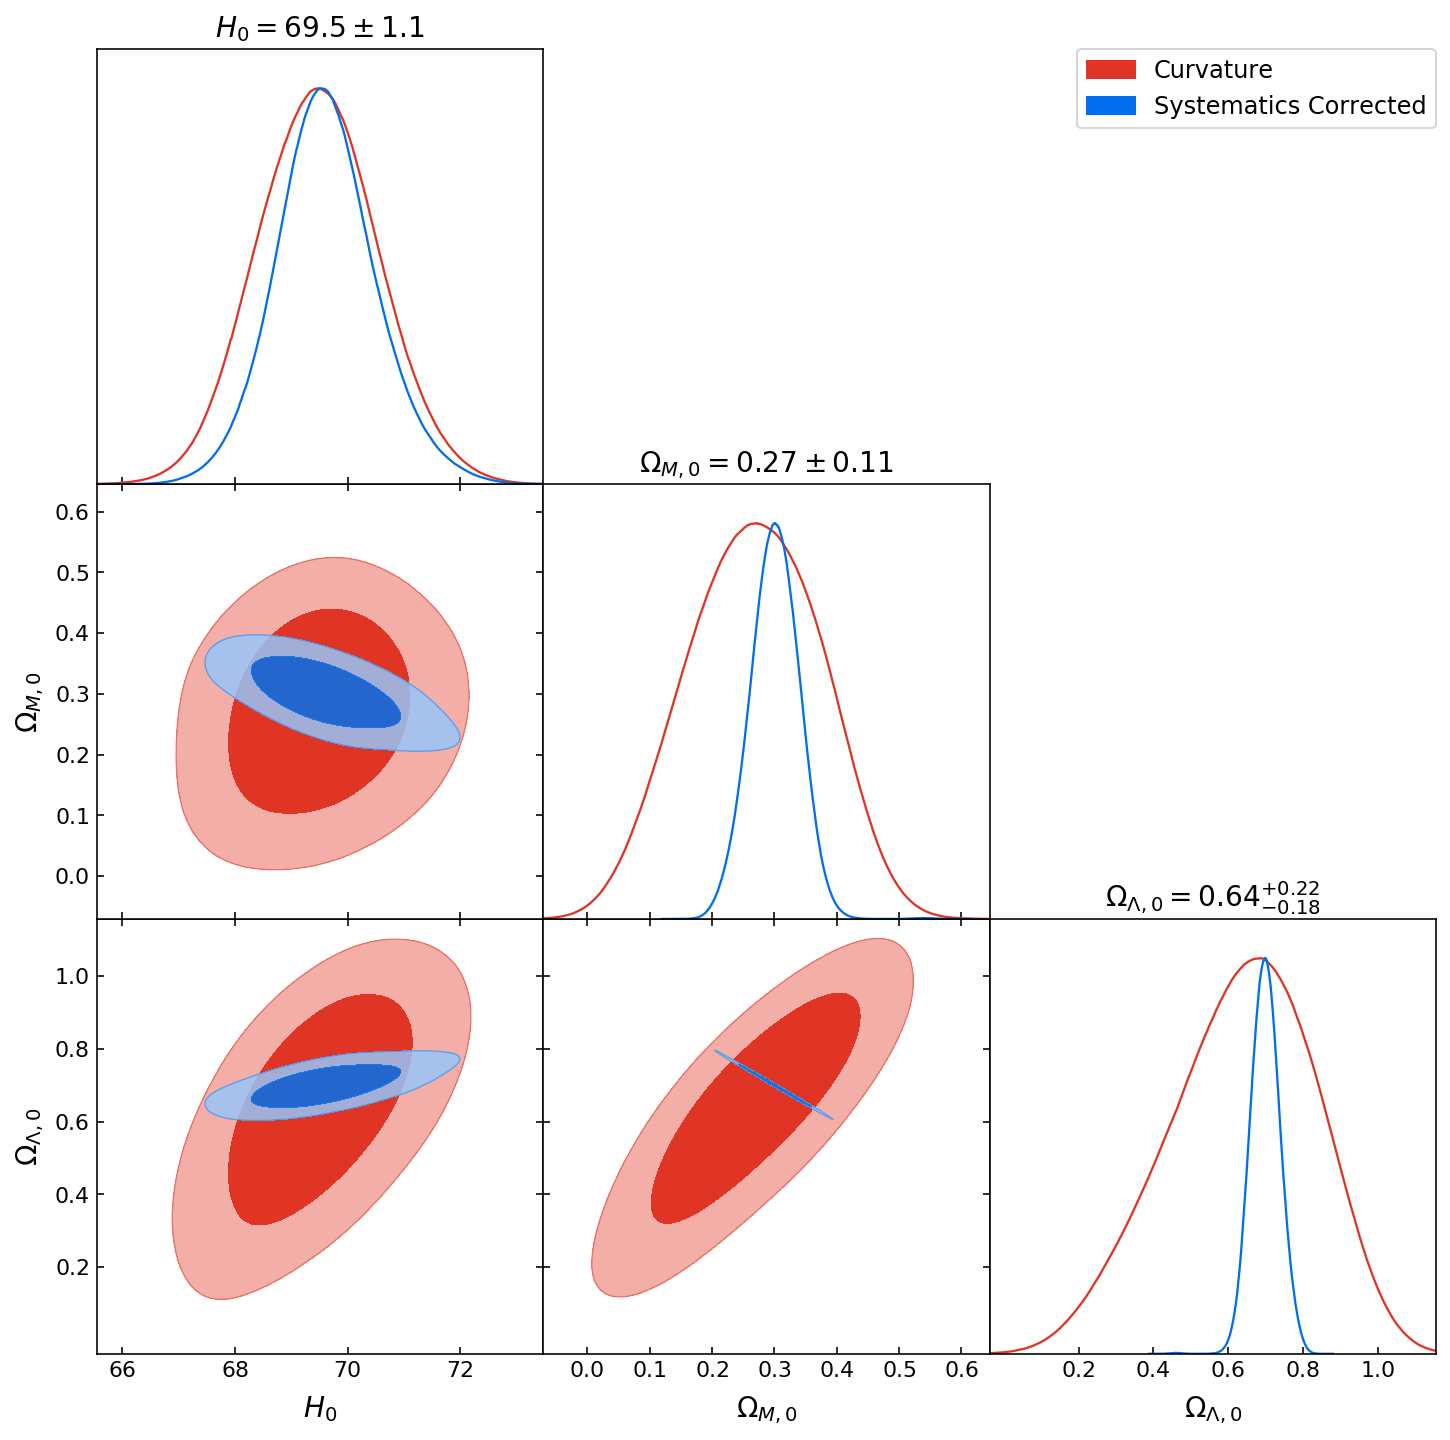

In [43]:
# extract the traces and plot the results
# O_L is not an independent parameter
pymc_traceL = np.asarray([traceL['H0'][:], traceL['OmM'][:],  traceL["O_L"][:]]).T
#pymc_trace_noL = np.asarray([traceL_no['H0'][:], traceL_no['OmM'][:], traceL["O_L"][:]]).T
names = ["H0", "OmM", "O_L"]
labels =  [r'H_0', r'\Omega_{M,0}', r'\Omega_{\Lambda,0}']
samplesL = MCSamples(samples=pymc_traceL, 
                    names = names, 
                    labels = labels, 
                    label = "Curvature", 
                    settings={'ignore_rows':0.3})
#samples_noL = MCSamples(samples=pymc_trace_noL,
#                       names = names,
#                      labels = labels,
#                       label = "Flat",
#                       settings={'ignore_rows':0.3})
# Triangle plot
g = plots.get_subplot_plotter(width_inch=12)
g.settings.title_limit_fontsize = 14
g.triangle_plot([samplesL,samples],
                filled=True,
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'alpha':27})
# g.export("bayes.png") #Save?

In [44]:
H_LIM = [traceL["H0"].min(), traceL["H0"].max()]
O_mLIM = [traceL["OmM"].min(), traceL["OmM"].max()]    
O_LLIM = [traceL["O_L"].min(), traceL["O_L"].max()]    

In [45]:
from scipy import integrate

def integrate_posterior_3D(log_posterior, xlim=H_LIM, ylim=O_mLIM , zlim=O_LLIM):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior(theta0, theta1, theta2))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])

In [46]:
%time Z2, err_Z2 = integrate_posterior_3D(log_likelihood, H_LIM, O_mLIM, O_LLIM)
print("Z2 =", Z2, "+/-", err_Z2)

CPU times: user 52min 36s, sys: 1h 34min 38s, total: 2h 27min 15s
Wall time: 22min 22s
Z2 = 2.8251273317340648e+48 +/- 4.900966703777554e+40


In [47]:
def integrate_posterior_2D(log_posterior, xlim, ylim):
    func = lambda theta1, theta0: np.exp(log_posterior(theta0, theta1))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

In [48]:
H_LIM = [trace["H0"].min(), trace["H0"].max()]
O_mLIM = [trace["OmM"].min(), trace["OmM"].max()]    

In [49]:
def log_likelihoodFlat(H0 = 60, OmM = 0.3):
    cosmoF = FlatLambdaCDM(H0=H0, Om0=OmM)
    mods = cosmoF.distmod(zs).value
    Delta = mu - mods
    return -LogDetSigma/2. - Delta.dot(invSigma.dot(Delta))/2


%time Z1, err_Z1 = integrate_posterior_2D(log_likelihoodFlat, H_LIM, O_mLIM)
print("Z1 =", Z1, "+/-", err_Z1)

CPU times: user 35.3 s, sys: 1min, total: 1min 35s
Wall time: 14.1 s
Z1 = 3.73701323771322e+48 +/- 4.534467245525153e+39


In [50]:
Z1/Z2

1.322776922560669

In [51]:
pm.stats.summary(traceL) 
pm.stats.summary(trace) 


/opt/conda/envs/cosmos3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
H0,69.474637,1.037361,0.049439,67.654955,71.569717,327.249233,1.003857
OmM,0.269634,0.106363,0.006615,0.068794,0.461792,181.996241,1.001576
O_L,0.638216,0.196529,0.012385,0.288101,0.999899,171.015822,1.001803


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
H0,69.650802,0.897052,0.041294,67.797222,71.381426,399.178422,1.003517
OmM,0.298875,0.040096,0.001784,0.214282,0.370520,425.755790,1.008478


## Bayesian Selection: Flat or Curved for the best fit?

In [52]:
df_comp = pm.compare((traceL, trace), (modelL, model))
df_comp
pm.compareplot(df_comp)

AttributeError: 'MultiTrace' object has no attribute 'name'

## Nuisance Parameters

## JLA full analysis with PYMC3

## JLA full analysis with Montepython

## First Cobaya Analysis